# Large-tile generation

TerraMind was pre-trained on small patches of 224x224 pixels. Passing larger inputs to the model works as long as it is a multiple of 16x16 pixel. However, this is outside the training scope and can lead to worse generation results or OOM errors. 
This example performs generation of a larger tile using the `tiled_inference` function provided by TerraTorch.  

In [1]:
import os
import torch
import rioxarray as rxr
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from plotting_utils import plot_s2, plot_modality
from terratorch.registry import FULL_MODEL_REGISTRY
from terratorch.tasks.tiled_inference import tiled_inference

# Select device
if torch.cuda.is_available():
    device = 'cuda'    
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

In [2]:
# Download Santiago large-scale example from Hugging Face (2000x2000 pixel)
if not os.path.isfile('../examples/S2L2A/Santiago.tif'):
    hf_hub_download(repo_id='ibm-esa-geospatial/Examples', filename='S2L2A/Santiago.tif', repo_type='dataset', local_dir='../examples/')

In [3]:
# Download Singpore large-scale example from Hugging Face (2000x2000 pixel)
if not os.path.isfile('../examples/S2L2A/Singapore_2025-01-09.tif'):
    hf_hub_download(repo_id='ibm-esa-geospatial/Examples', filename='S2L2A/Singapore_2025-01-09.tif', repo_type='dataset', local_dir='../examples/')

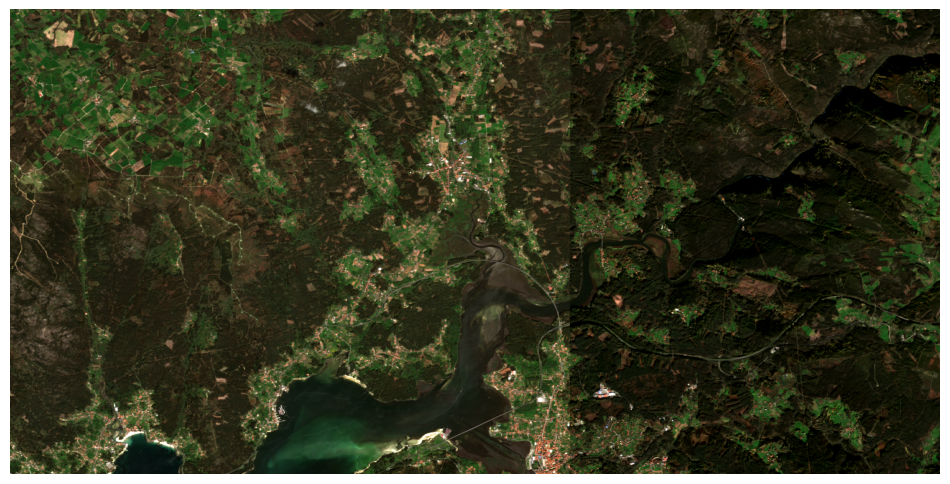

In [4]:
# Load Singapore tile
# data = rxr.open_rasterio('../examples/S2L2A/Singapore_2025-01-09.tif').values

# Load Santiago tile (alternative input)
data = rxr.open_rasterio('../examples/S2L2A/Santiago.tif').values

# Optionally reduce image size to speed up inference
data = data[:, 500:1500]

# Display the input 
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plot_s2(data, ax=ax)
plt.show()

In [5]:
# Build input tensor and add batch dimension
input = torch.tensor(data, dtype=torch.float, device=device).unsqueeze(0)

# Build model
model = FULL_MODEL_REGISTRY.build(
    'terramind_v1_base_generate',
    modalities=['S2L2A'],
    output_modalities=['S1GRD', 'DEM', 'LULC', 'NDVI'],
    pretrained=True,
    standardize=True,
    timesteps=10,  # Number of diffusion steps
)

model = model.to(device)

# Run inference

`tiled_inference` can be used with any model as long as the output of the passed `forward` function returns a tensor. We therefore wrap the model and stack the generated modalities. 

In [6]:
# Define model forward for tiled inference
def model_forward(x):
    # Run chained generation for all output modalities 
    generated = model(x)
    
    # TerraTorch tiled inference expects a tensor output from model forward. We concatenate all generations along channel dimension.     
    out = torch.concat([
        generated['S1GRD'],
        generated['DEM'],
        generated['LULC'],
        generated['NDVI']
    ], dim=1)
    
    return out 

pred = tiled_inference(model_forward, input, crop=256, stride=128, batch_size=16, verbose=True)
pred = pred.squeeze(0)  # Remove batch dim

# Split up the stacked bands into each modality
generated = {
    'S1GRD': pred[0:2],
    'DEM': pred[2],
    'LULC': pred[3:13].argmax(0),  # Get class predictions from logits
    'NDVI': pred[-1],
}

Tiled inference: 100%|██████████| 7/7 [01:15<00:00, 10.83s/it]


# Analyze the generations

Let's have a look at the generations. You can notice that all modalities capture the general features quite well but are often wrongly scaled. While S1 and NDVI values are closer to the mean values than the ground trough, DEM generations clearly shows the smaller patches of the tiled inference. The model fails to estimate the general elevation of each single patch. Because of the tiled inference, some generations can look a bit patchy, e.g., S1 below clouds as the model estimates the shoreline.

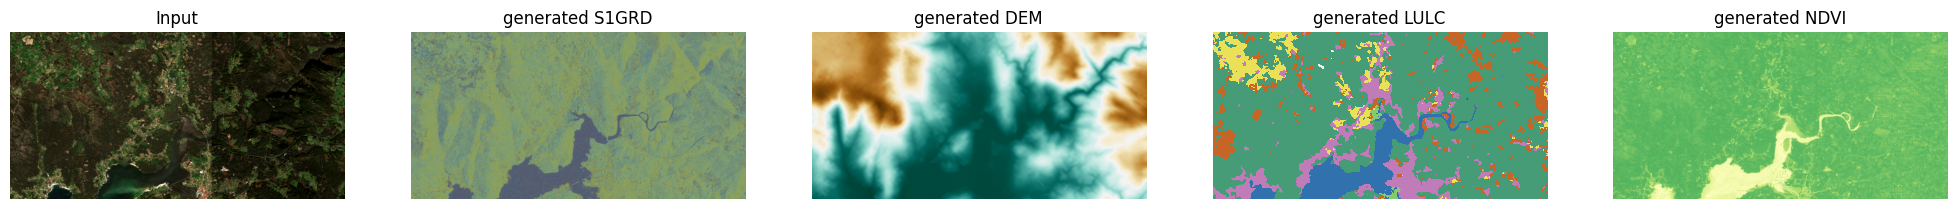

In [7]:
# Plot generations
n_plots = len(generated) + 1
fig, ax = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5))

plot_s2(input, ax=ax[0])
ax[0].set_title('Input')

for i, (mod, value) in enumerate(generated.items()):
    plot_modality(mod, value, ax=ax[i + 1])

    ax[i+1].set_title('generated ' + mod)
    
plt.show()

# Compare generations in split view

We use leafmap for the interactive visualisation of a generation.

In [ ]:
# Install leafmap
!pip install leafmap

In [ ]:
import leafmap
from plotting_utils import s2_to_rgb, s1_to_rgb, dem_to_rgb, ndvi_to_rgb, lulc_to_rgb

In [ ]:
# Plot comparison using leafmap 
leafmap.image_comparison(
    s2_to_rgb(input),
    s1_to_rgb(generated['S1GRD']),
    # dem_to_rgb(generated['DEM']),
    # ndvi_to_rgb(generated['NDVI']),
    # lulc_to_rgb(generated['LULC']),
    label1="S-2 L2A",
    label2="Generated data",
    starting_position=50,
    out_html="image_comparison.html",
)